# Initial Setup:
This step initializes the necessary configuration.

In [1]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / repo_dir / "RETFound_MAE"))

In [2]:
# Prerequisits
import json
import os
import shutil
from PIL import Image

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart, DatasetVersion
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI

# ML Analytics
import torch
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

In [3]:
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
catalog_id = "eye-ai" #@param
host = 'www.eye-ai.org'


gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-06-23 11:43:36,060 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-23 11:43:36,061 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


In [4]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-06-23 11:43:36,932 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-23 11:43:36,933 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


# Downloading Dataset:

In [5]:
source_dataset = "4-YWKJ" # USC test set
crop = True

if crop:
    asset_RID = ["4-QAGW"]  # RETFound cropped
else:
    asset_RID = ["4-QAGT"]  # RETFound uncropped

preds_workflow = EA.add_workflow( 
    Workflow(
        name="RETFound Predictions by KB",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/RETFound_Multi_Predict.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[ DatasetSpec(rid=source_dataset, version=EA.dataset_version(source_dataset), materialize=True) ],
    assets=asset_RID,
    workflow=preds_workflow,
    description=f"Instance of creating RETFound predictions: RETFound on 4-YWKJ USC Test with Crop = {crop}",
    )

execution = EA.create_execution(config)

2025-06-23 11:43:42,069 - INFO - Materialize bag 4-YWKJ... 
2025-06-23 11:43:42,302 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-23 11:43:42,303 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-23 11:43:43,574 - INFO - Using cached bag for  4-YWKJ Version:0.2.0
2025-06-23 11:43:43,574 - INFO - Loading /data/4-YWKJ_44b67c208c639554dd582f1575a7466fd853affad87411a7f99d28c7559acbbb/Dataset_4-YWKJ
2025-06-23 11:43:44,192 - INFO - Creating new database for dataset: 4-YWKJ in /data/kb_766/EyeAI_working/4-YWKJ@33F-J5QX-5CCA.db
2025-06-23 11:43:44,243 - INFO - Downloading assets ...
2025-06-23 11:44:42,901 - INFO - File [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/downloaded-assets/Execution_Asset/2-277G_cropped_Mar_11_2025.pth] transfer successful. 3471.44 MB transferre

In [6]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 4-YXAG
workflow_rid: 4-YX8A
asset_paths: {'Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/downloaded-assets/Execution_Asset/2-277G_cropped_Mar_11_2025.pth')]}
configuration: datasets=[DatasetSpec(rid='4-YWKJ', materialize=True, version=DatasetVersion(major=0, minor=2, patch=0))] assets=['4-QAGW'] workflow='4-YX8A' parameters={} description='Instance of creating RETFound predictions: RETFound Uncropped on 4-YWKJ USC Test' argv=['/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-fc264ea7-d1bc-498f-b427-e2efb050b8f9.json']


# Preprocessing:
Crop the images and move them to the designated folder for training, validation, and testing.          

In [7]:
ds_bag_test = execution.datasets[0]
model_path = str(execution.asset_paths['Execution_Asset'][0])

In [8]:
output_dir = execution._working_dir / execution.execution_rid
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

PosixPath('/data/kb_766/EyeAI_working/4-YXAG')

In [9]:
# FOR USC MULTIMODAL DATA
# Group files as glaucoma/not for RETFound evaluation

imageDF = ds_bag_test.get_table_as_dataframe('Image')
annotation_bounding_box =  pd.merge( ds_bag_test.get_table_as_dataframe('Annotation')[['Image', 'Fundus_Bounding_Box']], 
                                                ds_bag_test.get_table_as_dataframe('Fundus_Bounding_Box'), 
                                                left_on='Fundus_Bounding_Box', 
                                                right_on='RID')

data_path = output_dir / "dataset"
output_path =  data_path / "test"
output_path_no = output_path / "No_Glaucoma"
output_path_glaucoma = output_path / "Suspected_Glaucoma"

output_path.mkdir(parents=True, exist_ok=True)
output_path_no.mkdir(parents=True, exist_ok=True)
output_path_glaucoma.mkdir(parents=True, exist_ok=True)

for index, row in imageDF.iterrows():     
    src_path = row["Filename"]
    image_rid = row["RID"]
    dest_name = image_rid + ".jpg"
    if crop: dest_name = "Crop_" + dest_name
    label = image_rid.split( sep = "-" )[0]
    
    if label == "4":
        dest_path = os.path.join(output_path_no, dest_name)
    elif label == "2":
        dest_path = os.path.join(output_path_glaucoma, dest_name)
    else: 
        continue    
    
    if crop:
        image = Image.open(src_path)
        svg_path = annotation_bounding_box.loc[annotation_bounding_box['Image'] == image_rid, 'Filename'].values[0]
        svg_path = Path(svg_path)
        if not svg_path.exists():
          continue
        bbox = EA.get_bounding_box(svg_path)
        cropped_image = image.crop(bbox)
        cropped_image.save(dest_path)
    else:
        shutil.copy2(src_path, dest_path)

output_path

PosixPath('/data/kb_766/EyeAI_working/4-YXAG/dataset/test')

In [10]:
# Make train/val directories
# Necessary even if only evaluating

train_no = output_dir / "dataset" / "train" / "No_Glaucoma"
train_glacuoma = output_dir / "dataset" / "train" / "Suspected_Glaucoma"
val_no = output_dir / "dataset" / "val" / "No_Glaucoma"
val_glaucoma = output_dir / "dataset" / "val" / "Suspected_Glaucoma"

train_no.mkdir(parents=True, exist_ok=True)
train_glacuoma.mkdir(parents=True, exist_ok=True)
val_no.mkdir(parents=True, exist_ok=True)
val_glaucoma.mkdir(parents=True, exist_ok=True)

# Add single image to each ... again, necessary even if only evaluating
shutil.copy2( src_path, train_no )
shutil.copy2( src_path, train_glacuoma )
shutil.copy2( src_path, val_no )
shutil.copy2( src_path, val_glaucoma )

'/data/kb_766/EyeAI_working/4-YXAG/dataset/val/Suspected_Glaucoma/Multimodal_1324_Multimodal_2768_Multimodal_11567_Right_Field_2.jpg'

In [11]:
from datetime import datetime
current_date = datetime.now().strftime("%b_%d_%Y") 
print(current_date)

Jun_23_2025


In [12]:
! rm -r -f "./RETFound_output/"

In [13]:
RETFound_output = "./RETFound_output/task"
os.makedirs(RETFound_output, exist_ok= True)

# Training Arguments

<details>
  <summary>Click to expand</summary>

## General Training
- `--batch_size`: Batch size per GPU (default: `128`)
- `--epochs`: Number of training epochs (default: `50`)
- `--accum_iter`: Accumulate gradient iterations (default: `1`)

## Model Parameters
- `--model`: Name of model to train (default: `'RETFound_mae'`)
- `--input_size`: Image input size (default: `256`)
- `--drop_path`: Drop path rate (default: `0.2`)

## Optimizer Parameters
- `--clip_grad`: Clip gradient norm (default: `None`)
- `--weight_decay`: Weight decay (default: `0.05`)
- `--lr`: Learning rate (absolute) (default: `None`)
- `--blr`: Base learning rate (default: `5e-3`)
- `--layer_decay`: Layer-wise learning rate decay (default: `0.65`)
- `--min_lr`: Lower bound for cyclic schedulers (default: `1e-6`)
- `--warmup_epochs`: Number of warmup epochs (default: `10`)

## Augmentation Parameters
- `--color_jitter`: Color jitter factor (default: `None`)
- `--aa`: AutoAugment policy (default: `'rand-m9-mstd0.5-inc1'`)
- `--smoothing`: Label smoothing (default: `0.1`)

## Random Erase Parameters
- `--reprob`: Random erase probability (default: `0.25`)
- `--remode`: Random erase mode (default: `'pixel'`)
- `--recount`: Random erase count (default: `1`)
- `--resplit`: Do not random erase first augmentation split (default: `False`)

## Mixup Parameters
- `--mixup`: Mixup alpha (default: `0`, enabled if > 0)
- `--cutmix`: CutMix alpha (default: `0`, enabled if > 0)
- `--cutmix_minmax`: CutMix min/max ratio (default: `None`)
- `--mixup_prob`: Probability of performing Mixup or CutMix (default: `1.0`)
- `--mixup_switch_prob`: Probability of switching to CutMix (default: `0.5`)
- `--mixup_mode`: Mode of applying Mixup/CutMix (default: `'batch'`)

## Finetuning Parameters
- `--finetune`: Finetune from checkpoint (default: `''`)
- `--task`: Task type for finetuning (default: `''`)
- `--global_pool`: Use global pooling (default: `True`)
- `--cls_token`: Use class token instead of global pool (default: `False`)

## Dataset Parameters
- `--data_path`: Dataset path (default: `'./data/'`)
- `--nb_classes`: Number of classification categories (default: `8`)
- `--output_dir`: Path to save output (default: `'./output_dir'`)
- `--log_dir`: Path for TensorBoard logs (default: `'./output_logs'`)
- `--device`: Device to use for training/testing (default: `'cuda'`)
- `--seed`: Random seed (default: `0`)
- `--resume`: Resume from checkpoint (default: `''`)
- `--start_epoch`: Start epoch number (default: `0`)
- `--eval`: Perform evaluation only (default: `False`)
- `--dist_eval`: Enable distributed evaluation (default: `False`)
- `--num_workers`: Number of DataLoader workers (default: `10`)
- `--pin_mem`: Pin CPU memory in DataLoader for efficient GPU transfer (default: `True`)

## Distributed Training Parameters
- `--world_size`: Number of distributed processes (default: `1`)
- `--local_rank`: Local rank for distributed training (default: `-1`)
- `--dist_on_itp`: Enable distributed training on ITP (default: `False`)
- `--dist_url`: URL for distributed training setup (default: `'env://'`)

## Additional Fine-Tuning Parameters
- `--savemodel`: Save the trained model (default: `True`)
- `--norm`: Normalization method (default: `'IMAGENET'`)
- `--enhance`: Use enhanced data (default: `False`)
- `--datasets_seed`: Dataset random seed (default: `2026`)


# Train and Evaluate:

In [ ]:
from main_finetune import main, get_args_parser 
with execution.execute() as exec:
    args_list = [
        "--model", "RETFound_mae", # If you are using 4-S3KP asset, this would be RETFound_dinov2, which I would recommend take a look into.
        "--savemodel",
        "--global_pool",
        "--batch_size", "16",
        "--world_size", "1",
        "--epochs", "100",
        "--blr", "5e-3", "--layer_decay", "0.65",
        "--weight_decay", "0.05", "--drop_path", "0.2",
        "--nb_classes", "2",
        "--data_path", str(dataset_dir),
        "--input_size", "224",
        "--task", str(RETFound_output),
        "--output_dir", str(RETFound_output),
        "--finetune", str(retfound_pretrained_weight),
    ]

    args = get_args_parser().parse_args(args_list)
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)

    main(args)

# Evaluate Only:
If you already have a RETFound model, provide its path here to evaluate it directly.

2025-06-23 11:46:26.162832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 11:46:26.162878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 11:46:26.166615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 11:46:26.179580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-23 11:46:27.657711: W tensorflow/compiler/tf2

Not using distributed mode
[11:46:31.434624] job dir: /home/kb_766/Repos/RETFound_MAE
[11:46:31.434704] Namespace(batch_size=16,
epochs=100,
accum_iter=1,
model='RETFound_mae',
input_size=224,
drop_path=0.2,
clip_grad=None,
weight_decay=0.05,
lr=None,
blr=0.005,
layer_decay=0.65,
min_lr=1e-06,
warmup_epochs=10,
color_jitter=None,
aa='rand-m9-mstd0.5-inc1',
smoothing=0.1,
reprob=0.25,
remode='pixel',
recount=1,
resplit=False,
mixup=0,
cutmix=0,
cutmix_minmax=None,
mixup_prob=1.0,
mixup_switch_prob=0.5,
mixup_mode='batch',
finetune='',
task='./RETFound_output/task',
global_pool=True,
data_path='/data/kb_766/EyeAI_working/4-YXAG/dataset',
nb_classes=5,
output_dir='./RETFound_output/task',
log_dir='./output_logs',
device='cuda',
seed=0,
resume='/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/downloaded-assets/Execution_Asset/2-277G_cropped_Mar_11_2025.pth',
start_epoch=0,
eval=True,
dist_eval=False,
num_workers=10,
pin_mem=True,
early_stop_patience=0,
world_size=1,
local_rank=-1,
dis

/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[11:46:36.229943] Load checkpoint from: /data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/downloaded-assets/Execution_Asset/2-277G_cropped_Mar_11_2025.pth
[11:46:36.671486] number of model params (M): 303.31
[11:46:36.671615] base lr: 5.00e-03
[11:46:36.671632] actual lr: 3.13e-04
[11:46:36.671646] accumulate grad iterations: 1
[11:46:36.671658] effective batch size: 16
[11:46:36.676717] criterion = CrossEntropyLoss()
[11:46:37.903240] Resume checkpoint /data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/downloaded-assets/Execution_Asset/2-277G_cropped_Mar_11_2025.pth
[11:46:38.003494] Test with the best model at epoch = 38
[11:46:41.639115] test:  [ 0/19]  eta: 0:01:08  loss: 1.1102 (1.1102)  time: 3.6291  data: 2.4523  max mem: 1832
[11:46:43.368942] test:  [10/19]  eta: 0:00:04  loss: 1.0950 (1.1380)  time: 0.4871  data: 0.3269  max mem: 1833
[11:46:43.832529] test:  [18/19]  eta: 0:00:00  loss: 0.5700 (0.8352)  time: 0.3064  data: 0.1893  max mem: 1833
[11:46:44.043792] test:

/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/kb_766/.conda/envs/eye-ai-retfound/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
2025-06-23 11:46:44,

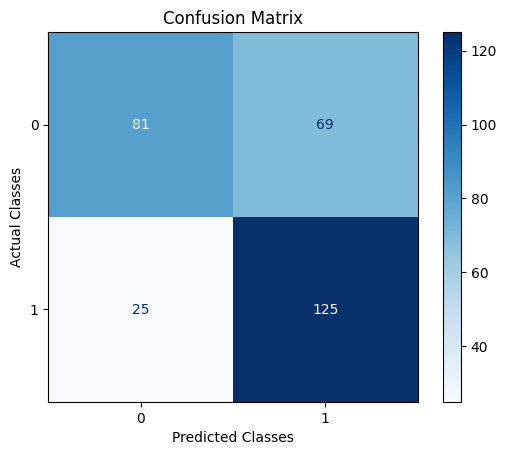

In [14]:
from main_finetune import main, get_args_parser 
with execution.execute() as exec:
    path_to_model = model_path
    args_list = [
        "--model", "RETFound_mae",
        "--eval",
        "--savemodel",
        "--global_pool",
        "--batch_size", "16",
        "--world_size", "1",
        "--epochs", "100",
        "--blr", "5e-3", "--layer_decay", "0.65",
        "--weight_decay", "0.05", "--drop_path", "0.2",
        "--nb_classes", "5",
        "--data_path", str(data_path),
        "--input_size", "224",
        "--task", str(RETFound_output),
        "--output_dir", str(RETFound_output),
        "--resume", path_to_model,
    ]

    args = get_args_parser().parse_args(args_list)
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)

    main(args)

In [15]:
#pd.read_csv('./RETFound_output/task/RETFound_output/task/metrics_test.csv')
pd.read_csv('./RETFound_output/task/RETFound_output/task/roc_predictions_test.csv')  

,Filename,True Label,Prediction,Probability Score
0,Crop_4-YRP6.jpg,0,0,0.1880
1,Crop_4-YRPA.jpg,0,1,0.6016
2,Crop_4-YRPE.jpg,0,0,0.4458
3,Crop_4-YRPG.jpg,0,1,0.8604
4,Crop_4-YRPJ.jpg,0,0,0.4478
...,...,...,...,...
295,Crop_2-C2ZR.jpg,1,1,0.9450
296,Crop_2-C382.jpg,1,1,0.9487
297,Crop_2-C38R.jpg,1,1,0.8010
298,Crop_2-C3DG.jpg,1,1,0.9470


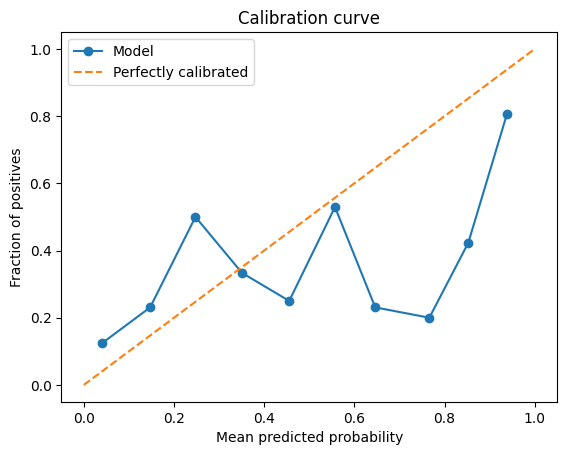

In [16]:
# Calibration curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

preds = pd.read_csv('./RETFound_output/task/RETFound_output/task/roc_predictions_test.csv') 
prob_true, prob_pred = calibration_curve( preds["True Label"], preds["Probability Score"], n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()

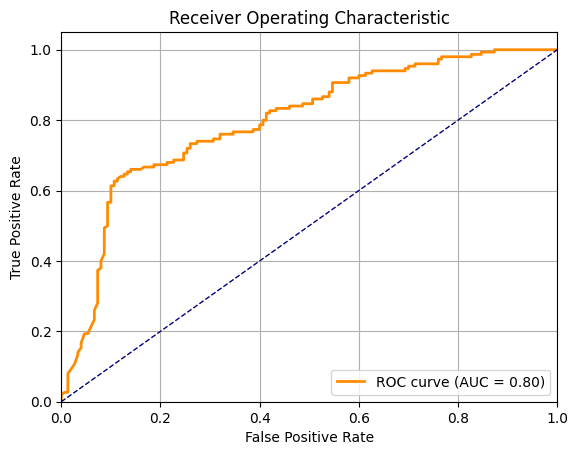

In [17]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report

y_true = preds["True Label"]
y_scores = preds["Probability Score"]
y_pred = preds["Prediction"]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [18]:
print( "ROC: ", roc_auc )
print( "Accuracy: ", accuracy_score(y_true, y_pred ) )
print( "Precision: ", precision_score(y_true, y_pred) )
print( "Recall: ", recall_score(y_true, y_pred) )
print( "F1: ", f1_score(y_true, y_pred) )

[11:47:23.549194] ROC:  0.7964666666666667
[11:47:23.550664] Accuracy:  0.6866666666666666
[11:47:23.552694] Precision:  0.6443298969072165
[11:47:23.554707] Recall:  0.8333333333333334
[11:47:23.556591] F1:  0.7267441860465116


# Upload results:
We now need to set up the paths to upload the files to the catalog. Please note that this process uploads a copy of the files, even when clean_folder=True. The original files will remain on your system in case you wish to revisit them later. However, you should consider deleting them afterward to conserve storage.

Alternatively, you can move the files directly to the corresponding path created by execution.asset_file_path(). This ensures that you are uploading the original files instead of creating a copy.

In [34]:
#This loop creates copies.
# for filename in os.listdir('./RETFound_output/task/RETFound_output/task/'):
#     file_path = os.path.join('./RETFound_output/task/RETFound_output/task/', filename)
#     if os.path.isfile(file_path):
#         asset_type = ""
#         if filename.endswith(('csv', 'jpg', 'txt')):
#             asset_type = "Model_Prediction"
#         elif filename.endswith('pth'):
#             asset_type = "Diagnosis_Model"
#         if asset_type != "":
#             path = execution.asset_file_path(
#                 asset_name="Execution_Asset",
#                 file_name=file_path,
#                 asset_types=asset_type
#             )
#             shutil.copy2(file_path, path)

AttributeError: 'Execution' object has no attribute 'execution_asset_path'

In [21]:
output_path

PosixPath('/data/kb_766/EyeAI_working/4-YXAG/dataset/test')

In [30]:
!ls /data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/asset/deriva-ml/Execution_Asset/

[12:05:25.742147] confusion_matrix_test.jpg  metrics_test.csv  roc_predictions_test.csv


In [28]:

asset_path = "/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/asset/deriva-ml/Execution_Asset/"
os.makedirs( asset_path, exist_ok=True )


In [29]:

for filename in os.listdir('./RETFound_output/task/RETFound_output/task/'):
    file_path = os.path.join('./RETFound_output/task/RETFound_output/task/', filename)
    if os.path.isfile(file_path):
        asset_type = ""
        if filename.endswith(('csv', 'jpg', 'txt')):
            asset_type = "Model_Prediction"
        elif filename.endswith('pth'):
            asset_type = "Diagnosis_Model"
        if asset_type != "":
            shutil.copy2(file_path, asset_path)

In [31]:
#Upload and end the execution
execution.upload_execution_outputs(clean_folder=True)

2025-06-23 12:05:28,340 - INFO - Uploading execution files...
2025-06-23 12:05:28,501 - INFO - Initializing uploader: GenericUploader v1.7.7 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2025-06-23 12:05:28,503 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-23 12:05:28,504 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-23 12:05:28,515 - INFO - Scanning files in directory [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/asset]...
2025-06-23 12:05:28,517 - INFO - Including file: [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/asset/deriva-ml/Execution_Metadata/configuration.json].
2025-06-23 12:05:28,518 - INFO - Including file: [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/asset/deriva-ml/Execution_Metadata/environment_sn

FileNotFoundError: [Errno 2] No such file or directory: '/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXAG/asset-type/deriva-ml/Execution_Asset.jsonl'